In [ ]:
pip install pandas numpy matplotlib seaborn scikit-learn openpyxl

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
# Load the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
df = pd.read_excel(url)

# Display the first few rows
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

df.info()  # Data types and null values
df.describe()  # Statistical summary

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
 8   TotalPrice   541909 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 37.2+ MB


,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalPrice
count,541909.000000,541909,541909.000000,406829.000000,541909.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570,17.987795
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000,-168469.600000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000,3.400000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000,9.750000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000,17.400000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000,168469.600000
std,218.081158,NaN,96.759853,1713.600303,378.810824


In [5]:
df = df.dropna(subset=['CustomerID'])

In [6]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [7]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [8]:
current_date = df['InvoiceDate'].max()
recency_df = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (current_date - x.max()).days})
recency_df.columns = ['Recency']

In [9]:
frequency_df = df.groupby('CustomerID').agg({'InvoiceNo': 'nunique'})
frequency_df.columns = ['Frequency']

In [10]:
monetary_df = df.groupby('CustomerID').agg({'TotalPrice': 'sum'})
monetary_df.columns = ['Monetary']

In [11]:
rfm_df = recency_df.join(frequency_df).join(monetary_df)

In [12]:
# Display the final RFM table
rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,1,7,4310.00
12348.0,74,4,1797.24
12349.0,18,1,1757.55
12350.0,309,1,334.40


In [13]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df)

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

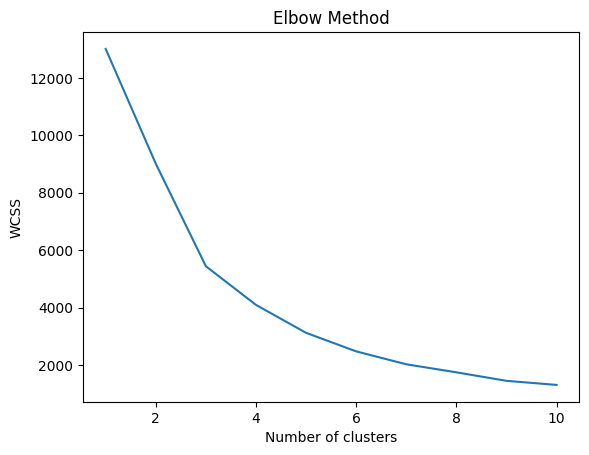

In [16]:
plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.savefig('elbow_method_plot_10_clusters.png')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [22]:
centroids = kmeans.cluster_centers_
print(centroids)

[[-0.48832448 -0.07656166 -0.07734781]
 [ 1.55535385 -0.35337933 -0.17507955]
 [-0.85149559 10.16828936 13.9387338 ]
 [-0.77034388  2.34650634  1.18542431]]


In [23]:
rfm_df.groupby('Cluster').mean().sort_values('Recency')

,Recency,Frequency,Monetary
Cluster,,,
2,6.384615,82.538462,127338.313846
3,14.500000,22.333333,12709.090490
0,42.702685,3.682711,1359.049284
1,247.075914,1.552015,480.617480


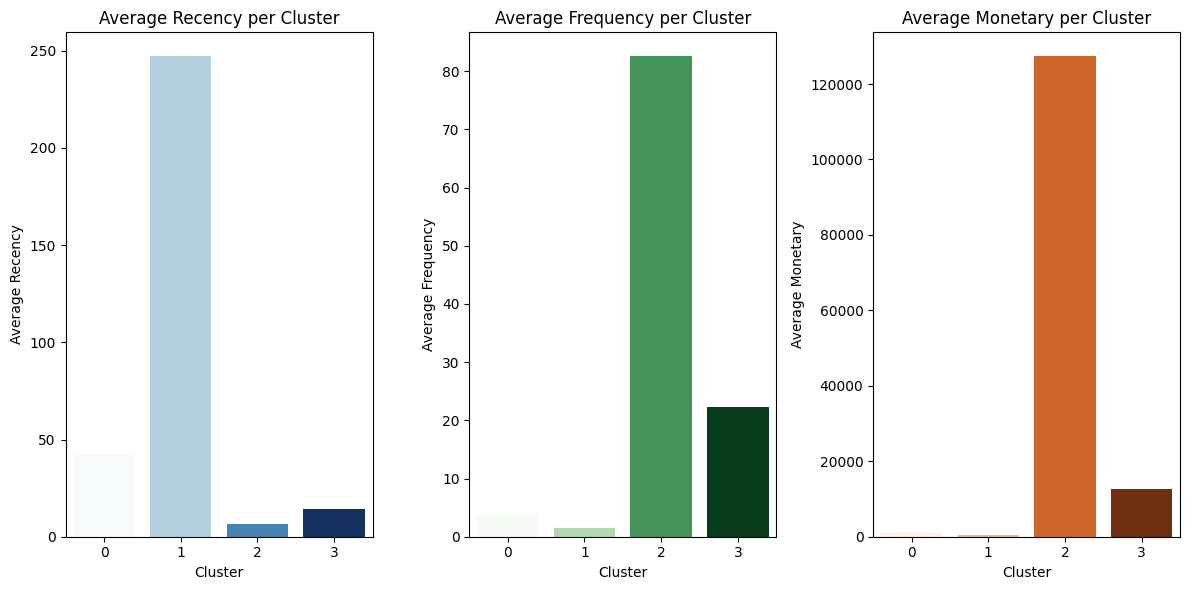

In [27]:
# Assuming the 'rfm_df' is already grouped by cluster and the mean values have been calculated
# Calculate the mean values for each cluster
rfm_means = rfm_df.groupby('Cluster').mean()

# Set up the plot size
plt.figure(figsize=(12, 6))

# Plot for Recency
plt.subplot(1, 3, 1)  # 1 row, 3 columns, first subplot
sns.barplot(x=rfm_means.index, y=rfm_means['Recency'], hue=rfm_means.index, palette='Blues', legend=False)
plt.title('Average Recency per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Recency')

# Plot for Frequency
plt.subplot(1, 3, 2)  # 1 row, 3 columns, second subplot
sns.barplot(x=rfm_means.index, y=rfm_means['Frequency'], hue=rfm_means.index, palette='Greens', legend=False)
plt.title('Average Frequency per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Frequency')

# Plot for Monetary
plt.subplot(1, 3, 3)  # 1 row, 3 columns, third subplot
sns.barplot(x=rfm_means.index, y=rfm_means['Monetary'], hue=rfm_means.index, palette='Oranges', legend=False)
plt.title('Average Monetary per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Monetary')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plots as an image file (e.g., PNG)
plt.savefig('rfm_cluster_barplots.png')

# Display the plots
plt.show()


In [28]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)

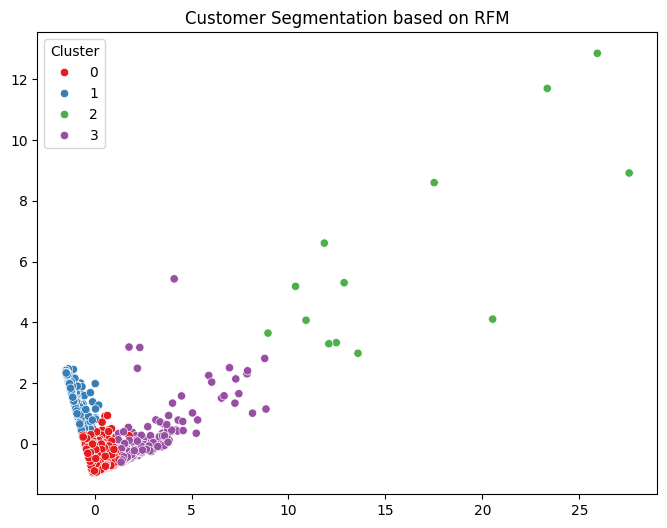

In [29]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=rfm_df['Cluster'], palette='Set1')
plt.title('Customer Segmentation based on RFM')
plt.savefig('customer_segmentation_based_on_RFM_plot.png')
plt.show()